In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae import *
import torch
import random
from torchvision.transforms import transforms as T
from pathlib import Path
from config import *
from utils import *
from conv_utils import *

import numpy as np
import platform
import json

architecture='conv_ae'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_conv_ae_sl_16
num selection:1 - exp name:4_wheel_system_conv_ae_sl_40


In [3]:
select_exp = '0'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_conv_ae_sl_16


In [4]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/conv_ae/4_wheel_system_conv_ae_sl_16/summary.csv


In [5]:
summary.reset_index().head(10)

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,39,30,"trainCONVAE_73d63_00022_22_activation=Elu,batc...",158705,0.003365,0.002362
1,38,34,"trainCONVAE_73d63_00035_35_activation=Relu,bat...",43595,0.006928,0.005409
2,37,25,"trainCONVAE_73d63_00011_11_activation=Relu,bat...",22745,0.009078,0.007661
3,36,24,"trainCONVAE_73d63_00031_31_activation=Relu,bat...",22745,0.009394,0.007957
4,35,29,"trainCONVAE_73d63_00010_10_activation=Elu,batc...",19225,0.010852,0.010366
5,34,19,"trainCONVAE_73d63_00009_9_activation=Relu,batc...",113855,0.011310,0.010366
6,33,17,"trainCONVAE_73d63_00016_16_activation=Relu,bat...",58619,0.012552,0.010820
7,32,5,"trainCONVAE_73d63_00020_20_activation=Elu,batc...",30775,0.011885,0.010932
8,31,38,"trainCONVAE_73d63_00007_7_activation=Elu,batch...",23305,0.011406,0.011060
9,30,2,"trainCONVAE_73d63_00037_37_activation=Elu,batc...",113105,0.014289,0.014531


In [6]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'activation': 'Elu', 'batch_size': 100, 'dilation': 1, 'epochs': 200, 'filter_num': 56, 'flattened': 1, 'increasing': 0, 'kernel_size': 7, 'latent_dim': 80, 'lr': 0.0003, 'lr_patience': 10, 'n_layers': 1, 'seq_in_length': 16}


In [7]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [8]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=device)
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [9]:
cols = cfg['dataset']['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

columns_subset = params_conf['columns_subset']
dataset_subset = params_conf['dataset_subset']

dataset = params_conf['dataset']
train_val_split = params_conf['train_val_split']

target = params_conf['target']
batch_size = params_conf['batch_size']
sequence_length = params_conf['sequence_length']
out_window = params_conf['out_window']
predict = params_conf['predict']
activation = params_conf['activation']
kernel_size = params_conf['kernel_size']
filter_num = params_conf['filter_num']
latent_dim = params_conf['latent_dim']
n_layers = params_conf['n_layers']

increasing = params_conf['increasing']
flattened = params_conf['flattened']

In [10]:
model = CONV_AE(in_channel=1,heigth=params_conf['sequence_length'], width=len(cfg['dataset']['columns']),
                        kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                 latent_dim=params_conf['latent_dim'], \
        n_layers=params_conf['n_layers'], activation = params_conf['activation'],
               increasing=increasing, flattened=flattened).to(device)

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal


In [11]:
model.load_state_dict(checkpoint['model_state_dict'])
par_nums = checkpoint['parameters_number']
model.to(device).eval()
print(count_parameters(model))
model

158705


CONV_AE(
  (act): ELU(alpha=1.0)
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv2d(1, 56, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
      (enc_lay_1): Sequential(
        (0): Conv2d(56, 28, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
    )
    (act): ELU(alpha=1.0)
    (encoder_layer): Linear(in_features=448, out_features=80, bias=True)
  )
  (decoder): Decoder(
    (nn_dec): Sequential(
      (dec_lay_0): Sequential(
        (0): ConvTranspose2d(28, 56, kernel_size=(2, 2), stride=(2, 2))
      

In [12]:
transform = T.Compose([
                       T.ToTensor(),
                       ])
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, cfg['dataset']['scaled'],cfg['dataset']['columns_subset']
                  , cfg['dataset']['dataset_subset'], cfg['dataset']['columns'], 
                 cfg['dataset']['train_val_split'], cfg['dataset']['sequence_length']
                  , cfg['dataset']['sequence_length'],  predict=False,
                 batch_size=4, transform=transform )

In [13]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches_conv(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 160


In [14]:
yo = model(x.to(device)).squeeze().to(device)
xs = torch.squeeze(x).to(device)
x_plot = x.squeeze().to(device)

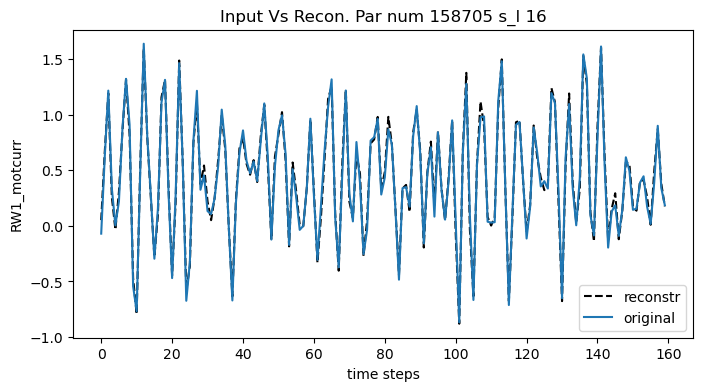

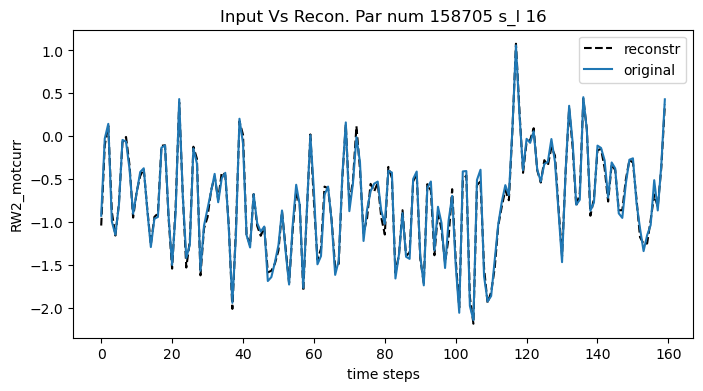

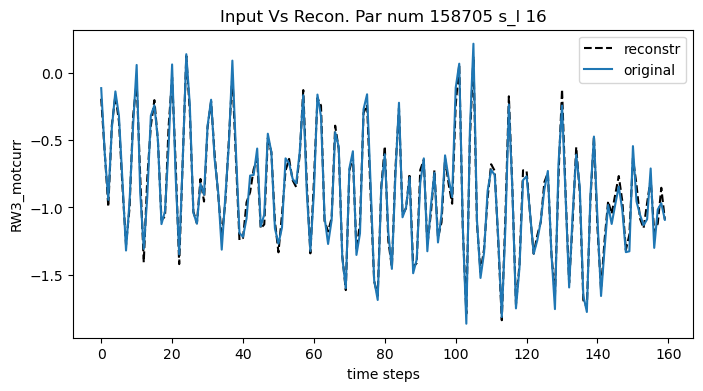

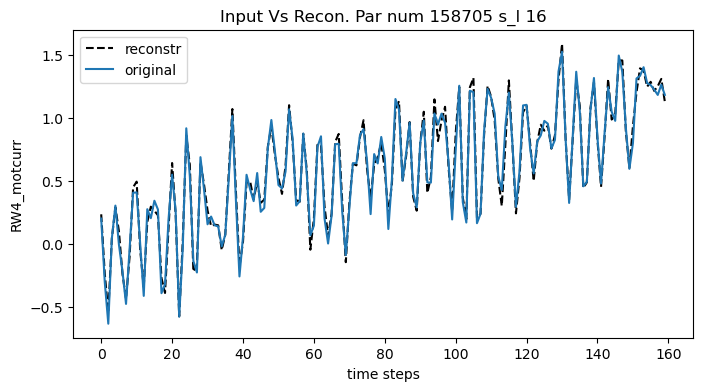

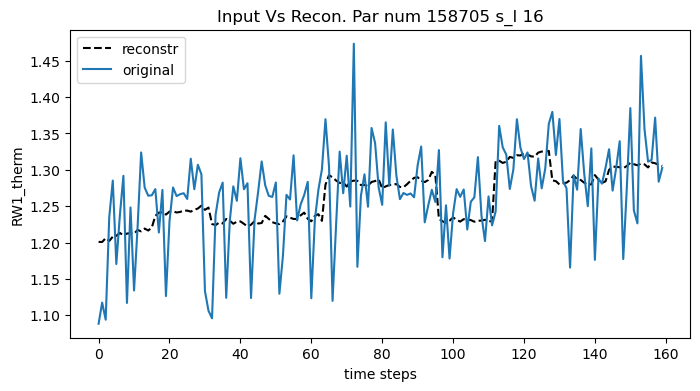

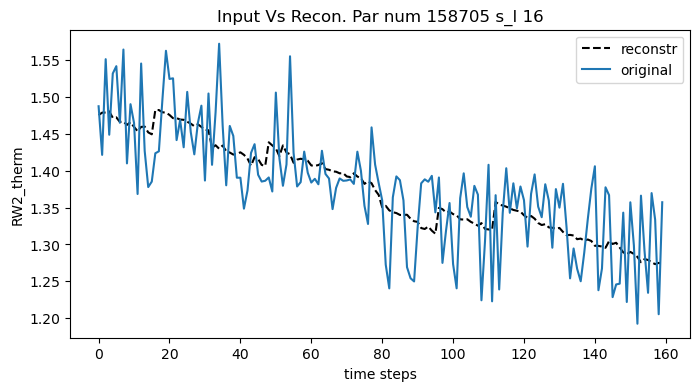

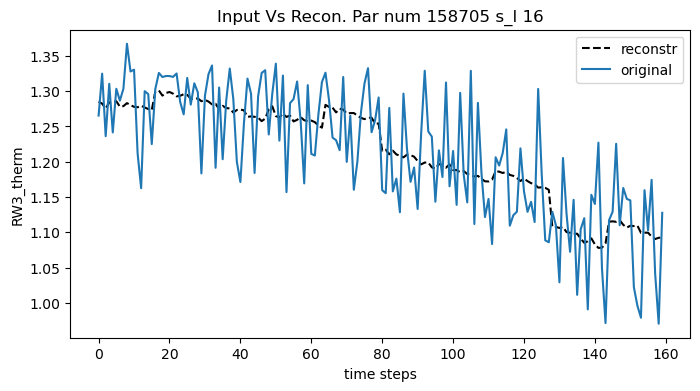

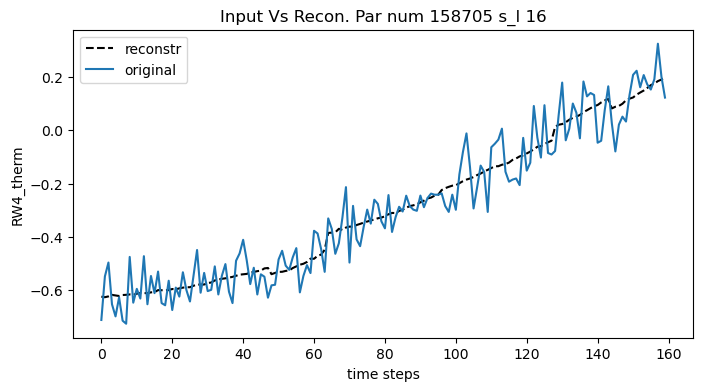

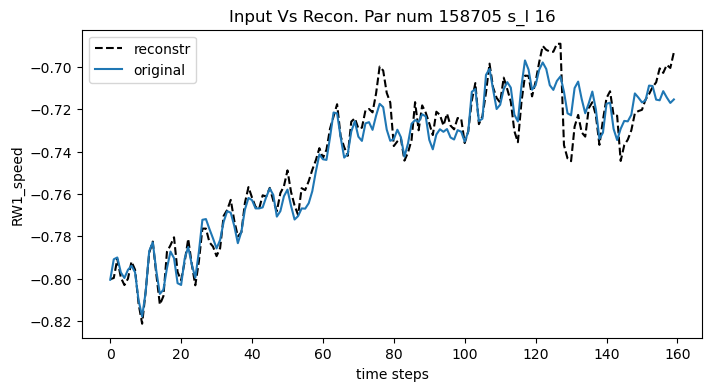

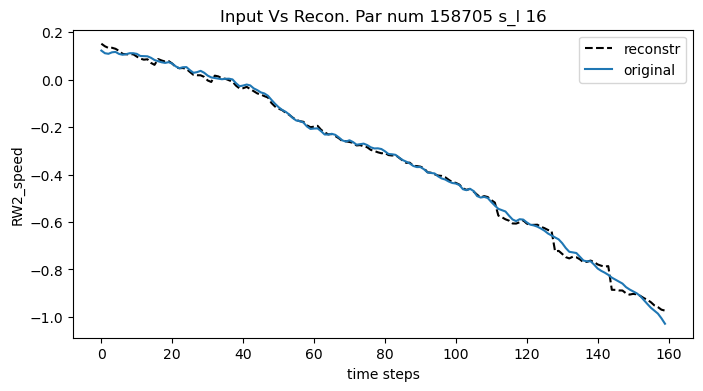

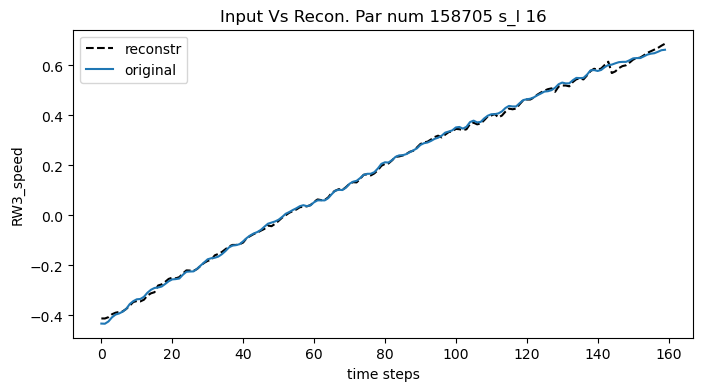

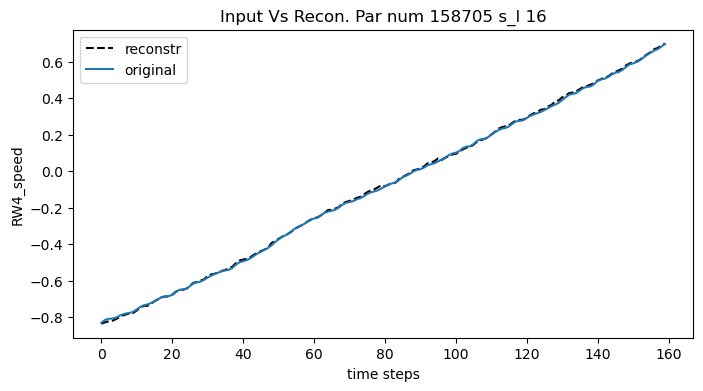

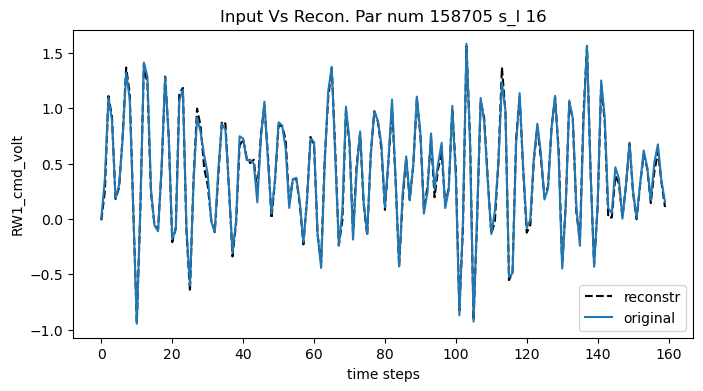

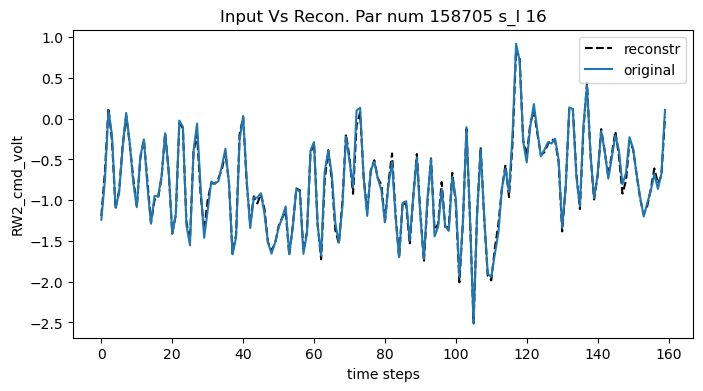

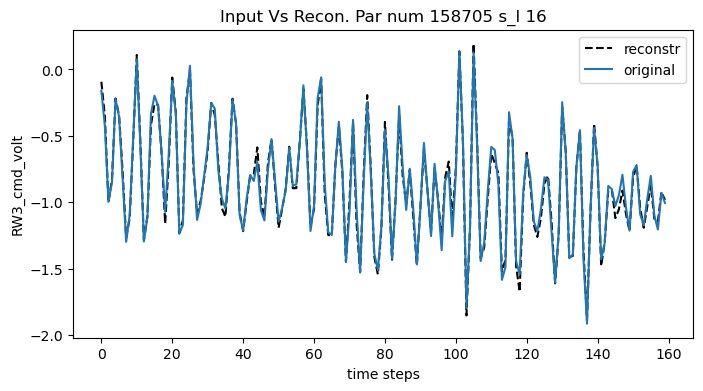

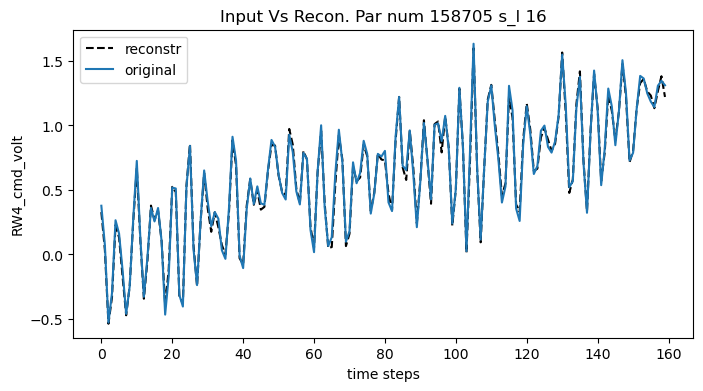

In [15]:
show_results(x_plot, yo,cols,
    model_name, params_conf,
    par_nums, shift,num_batch,
    arch=architecture,
    save=False,)